## Objectif

Ce notebook a pour objectif d'explorer et de démontrer les techniques de **Data Augmentation** et d'entraînement d'un modèle de réseau de neurones convolutifs (CNN) pour la classification d'images de radiographies pulmonaires. L'ensemble de données contient deux classes : **PNEUMONIA** et **NORMAL**. 

## Étapes de Démarche

1. **Vérification de la Disponibilité du GPU**
2. **Chargement et Préparation des Données**
   - Chargement, redimensionnement, conversion en niveaux de gris, normalisation et restructuration des images.
3. **Visualisation des Données**
4. **Augmentation des Données**
5. **Définition et Entraînement du Modèle CNN**
6. **Évaluation du Modèle**
7. **Visualisation des Performances**
   - Matrice de confusion, rapport de classification et courbe ROC.
8. **Heatmaps des Activations**

## Interprétation et Résultats
- **Courbes d'Apprentissage** : convergence du modèle et relation entre la perte et l'exactitude.
- **Matrice de Confusion** : répartition des erreurs de classification.
- **Rapport de Classification** : mesures détaillées comme la précision, le rappel et le score F1.
- **Courbe ROC** : capacité du modèle à distinguer les classes à différents seuils.
- **Heatmaps des Activations** : caractéristiques extraites par les couches du modèle.ion des données d'entrée.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Vérification de la Disponibilité des GPU pour Accélérer l’Entraînement du Modèle

Pour entrainer un modele, le fait d'utiliser un GPU (processeur graphique) peut accélérer les calculs et ca réduit le temps d'entrainement.

In [6]:
print("Nb de GPU Disponible: ", len(tf.config.experimental.list_physical_devices('GPU')))

Nb de GPU Disponible:  0


## Définition des constantes

In [9]:
img_size = 150
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'

## Chargement et prétraitement des images à partir des 2 dossiers

La fonction prend en entrée deux chemins de répertoire (data_dir1 et data_dir2) et retourne un tableau contenant les images redimensionnées et leurs étiquettes respectives.

In [14]:
def load_data(data_dir1, data_dir2):
    data = [] # initialisation d'une liste qui va stocker les imgs et les étiquettes (PNEUMONIA ou NORMAL)
    labels = ['PNEUMONIA', 'NORMAL'] # liste des labels possibles
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir) # consutruction de la path
        # on verifie si le chemin existe
        if(not (os.path.exists(path))):
            print(f"Le répertoire n'existe pas")
            continue
        label = os.path.basename(dir) # pour avoir le nom du répertoire qui correspond à l'étiquette
        class_num = labels.index(label) # conversion du nom de la classe en numéro
        # parcourir tous les fichiers du répertoire
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # on lit l'image au niveau gros (car les images qu'on a sont a noir et blanc)
                if img_arr is None:
                    print(f"Failed to read {img}. Skipping.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # redimensionnement de l'image
                data.append([resized_arr, class_num]) # ajout de l'image redimensionné et son label
            except Exception as e:
                print(e)
    return np.array(data, dtype=object) # on convertit la liste data en un tableau NumPy, juste parceque c'est plus efficace et ensuite on le retourne

train_data = load_data(data_dir1, data_dir2)

## Visualisation du nombre d'images par classe

Pour mieux comprendre la distribution des images dans chaque classe (**PNEUMONIA** ou **NORMAL**), on crée une visualisation qui montre combien d'imahges sont présntes dans chaque classe. 
Ca permet d'évaluer si les données sont équilibrées (dans le cas contraire : sur-représentés ou sous-représentés)

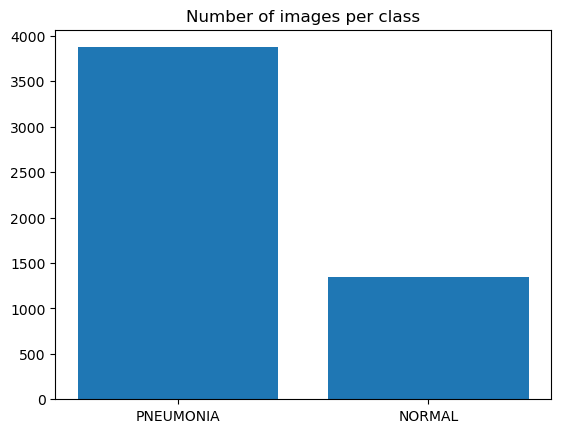

In [17]:
labels_count = [0, 0]
# on parcourt chaque élément de train_data (les données chargées et pré-traitées)
for item in train_data:
    labels_count[item[1]] += 1 # chaque élément 'item' est une liste qui a une img et son label de classe

# graphique
plt.bar(['PNEUMONIA', 'NORMAL'], labels_count)
plt.title('Number of images per class')
plt.show()

## Prétraitement des Données : Normalisation et Reshaping

Avant d'entrainer un modele, il faut toujours de préparer les données correctement.

- **Séparer les données en Feature et Labels** : 
  -  Features : images
  -  Labels : labels (étiquettes) qui indiquent la classe de chaque image

- **Normaliser** : 
  - Chaque pixel d'une image a une valeur entre 0 et 255.
  - Normaliser signifie diviser ces valeurs par 255 pour qu'elles soient entre 0 et 1.
  - Cela facilite l'entraînement du modèle parceque les valeurs sont plus petites et plus uniformes. Cela peut améliorer les performances du modèle.

- **Reshaper** :
  - Les images sont des tableaux de nombres (valeurs des pixels).
  - Reveut direignifie réorganiser ces tableaux pour qu'ils aient une forme spécifique.
  - On veut que chaque image ait la forme (nombre d'images, 150, 150, 1).
  - Cela indique qu'on a un certain nombre d'images, que chaque image a une taille de 150x150 pixels, et qu'elle est en niveaux de gris (1 canal de couleur).

In [20]:
# separation des caracteristiques et des etiquettes
def separate_features_labels(data):
    features, labels = [], [] # init de 2 listes vides qui
    for feature, label in data:
        features.append(feature) # ajout du feature à la liste
        labels.append(label) # ajout du label à la liste
    return np.array(features), np.array(labels) # on convertit les listes features et labels en tableaux NumPy et on retourne ces tableaux

x_train, y_train = separate_features_labels(train_data)

# normalisation des donnees
x_train = x_train / 255.0
x_train = x_train.reshape(-1, img_size, img_size, 1)

## Vérification des Données et Augmentation des Images

Avant d'entrainer un modele, il faut aussi vérifier si les données sont bien chargées et non vides.
Si les tableaux de données ```x_train``` et ```y_train``` contiennent des données, alors on peut générer des images pour augmenter les données d'entrainement.

Cette augmentation des données aide à enrichir la diversité des images d'entrainement.

In [23]:
# S'assurer que les données ne sont pas vides
if x_train.size == 0 or y_train.size == 0:
    print("Training data is empty. Please check the data loading process.")
else:
    # Augmenter les données
    datagen = ImageDataGenerator( # creer un outil pour augmenter les données d'entraînement
        rotation_range=30, # faire tourner les images de maniere random jusqu'à 30 degres
        width_shift_range=0.2, # deplacer les images horizontalement de maniere random jusqu'à 20% de leur largeu.
        height_shift_range=0.2, # deplacer les images verticalement de maniere random jusqu'à 20% de leur hauteur
        shear_range=0.2, # incliner les images de maniere random
        zoom_range=0.2, # zoomer sur les images de maniere random jusqu'à 20%
        horizontal_flip=True, # retourner les images horizontalement de maniere random
        fill_mode='nearest' # remplir les pixels manquants apres les transformations en utilisant le pixel le plus proche
    )
    datagen.fit(x_train)

## Affichage de quelques exemples d'images augmentées

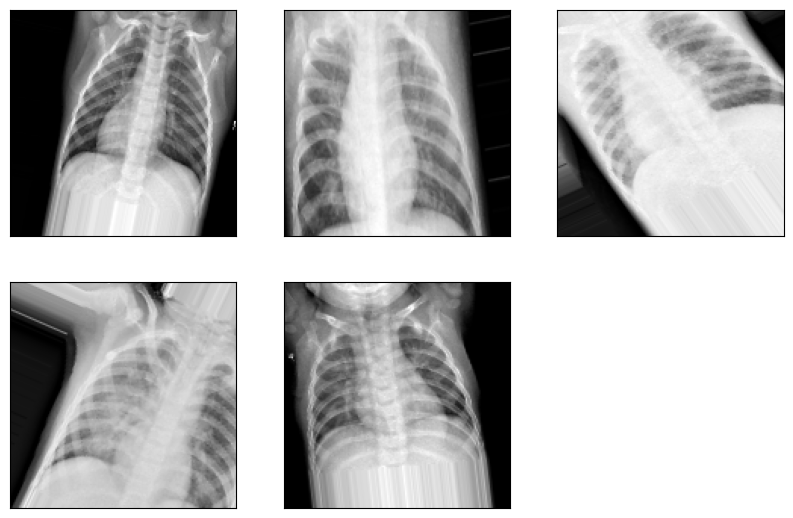

In [26]:
def display_augmented_images(datagen, x_train, y_train):
    plt.figure(figsize=(10, 10)) # création d'une nouvelle figure de taille 10x10 pouces
    # pour generer et afficher les images augmentées et chaque lot(batch) contient 5 images
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=5):
        # pour afficher chaque image dans le lot
        for i in range(5):
            plt.subplot(330 + 1 + i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(x_batch[i].reshape(img_size, img_size), cmap='gray')
        plt.show()
        break

display_augmented_images(datagen, x_train, y_train)

## Création d'un Modèle CNN (Convolutional Neural Network)

Un CNN est crée pour traiter les images et extraire des caractéristiques importantes à différentes niveaux de complexité.
Pour créer un modele de CNN, il faut suivre ces étapes :

- **Couche de Convolution** : Extrait les caractéristiques de l'image.
- **Couche de Pooling** : Réduit la taille de l'image tout en conservant les caractéristiques importantes.
- **Couche de Dropout** : Réduit le surapprentissage en désactivant aléatoirement des neurones.
- **Couche Dense** : Effectue la classification.
- **Compilation** : Utilise l'optimiseur Adam et la perte cross-entropy pour entraîner le modèle.

In [29]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)), # couche de convolution avec 32 filtres de taille 3x3
    MaxPooling2D((2, 2)), # couche de pooling maximal avec une fenetre de taille 2x2
    Dropout(0.2), # couche de dropout avec un taux de 0,2 (20% de neurones sont désactivés de manière random pour éviter le "surapprentissage")
    
    Conv2D(64, (3, 3), activation='relu'), # 2ème couche  de convolution avec 64 filtres de taille 3x3 et une fonction d'activation "relu"
    MaxPooling2D((2, 2)), # 2ème couche de Maxpooling maximal avec une fenetre de taille 2x2
    Dropout(0.2), # 2ème couche de dropout avec un taux de 0.2
    
    Flatten(), # couche de mise à plat (flattening) pour convertir les données 2D en vecteur 1D
    Dense(128, activation='relu'), # couche de dense avec 128 neurones et une fonction d'activation "relu"
    
    Dropout(0.5), # 3ème couche de dropout avdc un taux de 0.5
    Dense(1, activation='sigmoid') # couche de sortie dense avec 1 neurone et une fonction d'activation "sigmoid"
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # compilation du modèle

C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Configuration des Callbacks pour l’Entraînement du Modèle

Les callbacks permettent de surveiller et contoler le processus d'entrainement du modele. Ils permettent d'ajuster des paramètres automatiquement ou même d'interrompre l'entrainement.

- **Ajustement du taux d'apprentissage** : ce taux permet de déterminer la vitesse à laquelle le modele apprend. Si le modele n'améliore plus ses résultats, alors on peut utiliser un callback pour réduire le taux d'apprentissage  automatiquement. Ca permet au modele d'apprendre plus doucement et de trouver de meilleures solutions.
- **Arret Anticipé (Early-stopping)** : arret de l'entrainement du modele si la performance ne s'améliore plus. Ca evite d'entrainer le modele trop longtemps et de gaspiller des trucs et ça évite su sur-apprentissage
- **Entrainement du modele avec les données augmentées** : après avoir configuré les callbacks, on enrtaine le modele avec les données augemntées avec ces callbacks pour ajuster le taux d'apprentissage et interrompre l'entrainement si besoin.